*** Work in Progress ***

In [1]:
import pandas as pd
import numpy as np
import json
import datetime  # needed for eval() function
from collections import Counter  
from matplotlib import pyplot as plt
# import re
# import csv
from Modules.pubmed_import import search_and_dump
from Modules.process_pubmed_data import get_author_info, create_df
import networkx as nx

In [2]:
# File Paths
device_pubmed = './JSON_Data/device_pubmed_data.json'
biomed_pubmed = './JSON_Data/biomed_pubmed_data.json'

device_author = './JSON_Data/device_author_data.json'
biomed_author = './JSON_Data/biomed_author_data.json'

In [12]:
# def create_df(file_path, clean_years=True, cutoff_year=2000, remove_errors=False):
#     with open(file_path, "r") as f:
#         full_dict = json.load(f)
    
#     # slim_dict = {key:value for (key, value) in full_dict.items() if key in ["Pubmed ID", "Title", "Journal", "Date"]}
#     df = pd.DataFrame.from_dict(full_dict)
#     if remove_errors:
#         df = df[df["Pubmed ID"] != "000"]  # Removes data with parsing error
    
#     # Cleaning years
#     if clean_years:
#         df["Date"] = df["Date"].apply(lambda x : eval(x).year)  # Converts date from __repr__ format
#         for index in df.loc[df["Date"] > cutoff_year].index:
#             df.drop([index], inplace=True)
    
#     return df

# Retrieve Data

### Queries

In [10]:
# Searches for items with "medical device(s)" in the title or abstract
# search_and_dump(query_string='''(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) 
#                                 AND (("1850"[Date - Publication] : "2004"[Date - Publication]))''',
#                max_results=3000, file_name="device_pubmed_data.json", create_json=True)

In [11]:
# Searches for all items under the biomedical technolgy and engineering MESH headings
# search_and_dump(query_string='''("Biomedical Technology"[Mesh] OR "Biomedical Engineering"[Mesh]) 
#                                 AND (1900:2004[pdat]) AND (english[Language])''',
#                max_results=10000, file_name="biomed_pubmed_data.json", create_json=True)

# Publication Analysis

Some articles are listed with abnormal years (e.g. years outside of the range that was input to the query). This is a problem that seems to exists even in the browser version of PubMed. These errors are not randomly distributed. They overwhelmingly happen in the final year of the search range. My current solution is to extend the search range beyond what I want (up to the year 2000), then discarding all values outside of my target date range. This should pick up most of the incorrectly labeled data.

In [3]:
device_df = create_df(device_pubmed, clean_years=True, cutoff_year=2000, remove_errors=False)
biomed_df = create_df(biomed_pubmed, clean_years=True, cutoff_year=2000, remove_errors=False)

### Publications by Year

In [14]:
def plot_articles_by_year(df, title):
    '''
    This function plots the number of articles published each year.
    '''
    df_year = df.groupby(['Date'])['Pubmed ID'].count()
    df_year.plot(kind='bar')

    plt.xlabel('Year')
    plt.ylabel('Number of Articles')
    plt.title(title)
    plt.xticks(np.arange(0, len(df_year), step=5), rotation=90)
    plt.show()

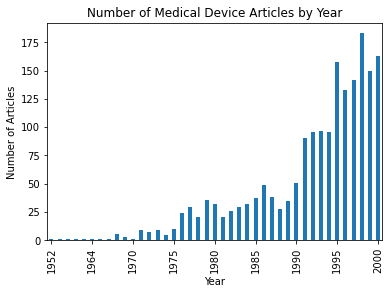

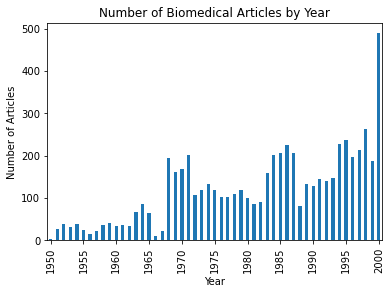

In [15]:
plot_articles_by_year(device_df,'Number of Medical Device Articles by Year')
plot_articles_by_year(biomed_df,'Number of Biomedical Articles by Year')

### For Export to Voyant Tools

In [16]:
def voyant_export(year_group, dataset_name, start_year, end_year=2000):
    year_title_list = year_group["Title"].unique()
    
    for year in range(start_year, end_year + 1):
        temp_list = []
        try:
            for title in year_title_list[year]:
                title = title.replace("--", " ")
                title = title + "\n"
                temp_list.append(title)
            
            with open("Title Data Files/{a}/{b}_{a}.txt".format(b=year, a=dataset_name), "w") as f:
                f.writelines(temp_list)
       
        except KeyError:  # If there were no publication in a year in the range
            pass
    
    print("Data Exported")

In [17]:
# voyant_export(year_group = device_date_group, dataset_name="med_dev", start_year=1952, end_year=2000)
# voyant_export(year_group = biomed_date_group, dataset_name="biomed", start_year=1950, end_year=2000)

Medical Device Publication Word Frequency: https://voyant-tools.org/?corpus=fa33b04ff82a6bb8eb2bb7c2b5c9837a&panels=corpusterms,termsberry,trends,summary,contexts

Biomedical Publication Corpus: https://voyant-tools.org/?corpus=d27c6e29211b43ce02d1d96f182704ae

# NetworkX Graph

In [4]:
def open_json(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
    return data

In [5]:
def check_in_range(list1, date_strt, date_end):
    '''
    Check if any value in list1 is in date range
    '''
    for i in range(len(list1)):
        if list1[i] >= date_strt and list1[i] < date_end:
            return True

In [6]:
def make_adj_list(author_data, out_file, date_strt, date_end):
    '''
    Build multiline adjacency list from author JSON file
    '''
    with open(out_file, 'wt') as out_file:
        for author in author_data:
            years_active = [eval(year) for year in author_data[author]['years active']]
            coauthor_list = [i[0] for i in author_data[author]['edges'] if check_in_range([eval(i[2])], date_strt, date_end)]
            weights = Counter(coauthor_list)

            if check_in_range(years_active, date_strt, date_end):
                out_file.write(str(author_data[author]['id']) + ' ' + '{}'.format(len(coauthor_list)) + '\n')
                for coauthor in coauthor_list:
                    out_file.write(str(author_data[coauthor]['id']) + ' ' + "{'weight': %s}" % weights[coauthor] + '\n')

In [19]:
# Create JSON file
get_author_info(create_df(biomed_pubmed, clean_years=False, remove_errors=False), cutoff_year=2000, write_file_name=biomed_author)

In [8]:
# Process JSON in multiline adjacency list format
bio_multi_adj = './JSON_Data/biomed_multiline.csv'
make_adj_list(open_json(biomed_author), bio_multi_adj, date_strt=datetime.date(1970, 1, 1), date_end=datetime.date(1980, 1, 1))

In [9]:
G = nx.read_multiline_adjlist(path=bio_multi_adj, create_using=nx.Graph())

In [13]:
G['234']

AtlasView({'9417': {'weight': 1}, '9419': {'weight': 1}, '10677': {'weight': 1}, '10796': {'weight': 1}, '10797': {'weight': 1}})

In [14]:
G['9417']

AtlasView({'234': {'weight': 1}, '9419': {'weight': 1}})